In [18]:
import re
import pandas as pd
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
from nltk import punkt
from nltk import *
nltk.download('stopwords')
from pymystem3 import Mystem
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('russian'))
import pymorphy2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import os
import io


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayk20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayk20\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
p = pd.read_csv('persons_primier.csv',sep=',')
d = pd.read_csv('diaries_premier.csv',sep=',')
m = Mystem()

dp = p.merge(d, left_on='prozhito_id', right_on='person')

dp.to_csv('persons_daries.csv')

Обработано записей:  67
12


C:\Users\ayk20\AppData\Local\Temp\ipykernel_36392\2960097194.py:67: UserWarning: 
The palette list has fewer values (1) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot_clean = sns.barplot(x="counts",
C:\Users\ayk20\AppData\Local\Temp\ipykernel_36392\2960097194.py:40: UserWarning: 
The palette list has fewer values (1) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot_dirty = sns.barplot(x="counts",


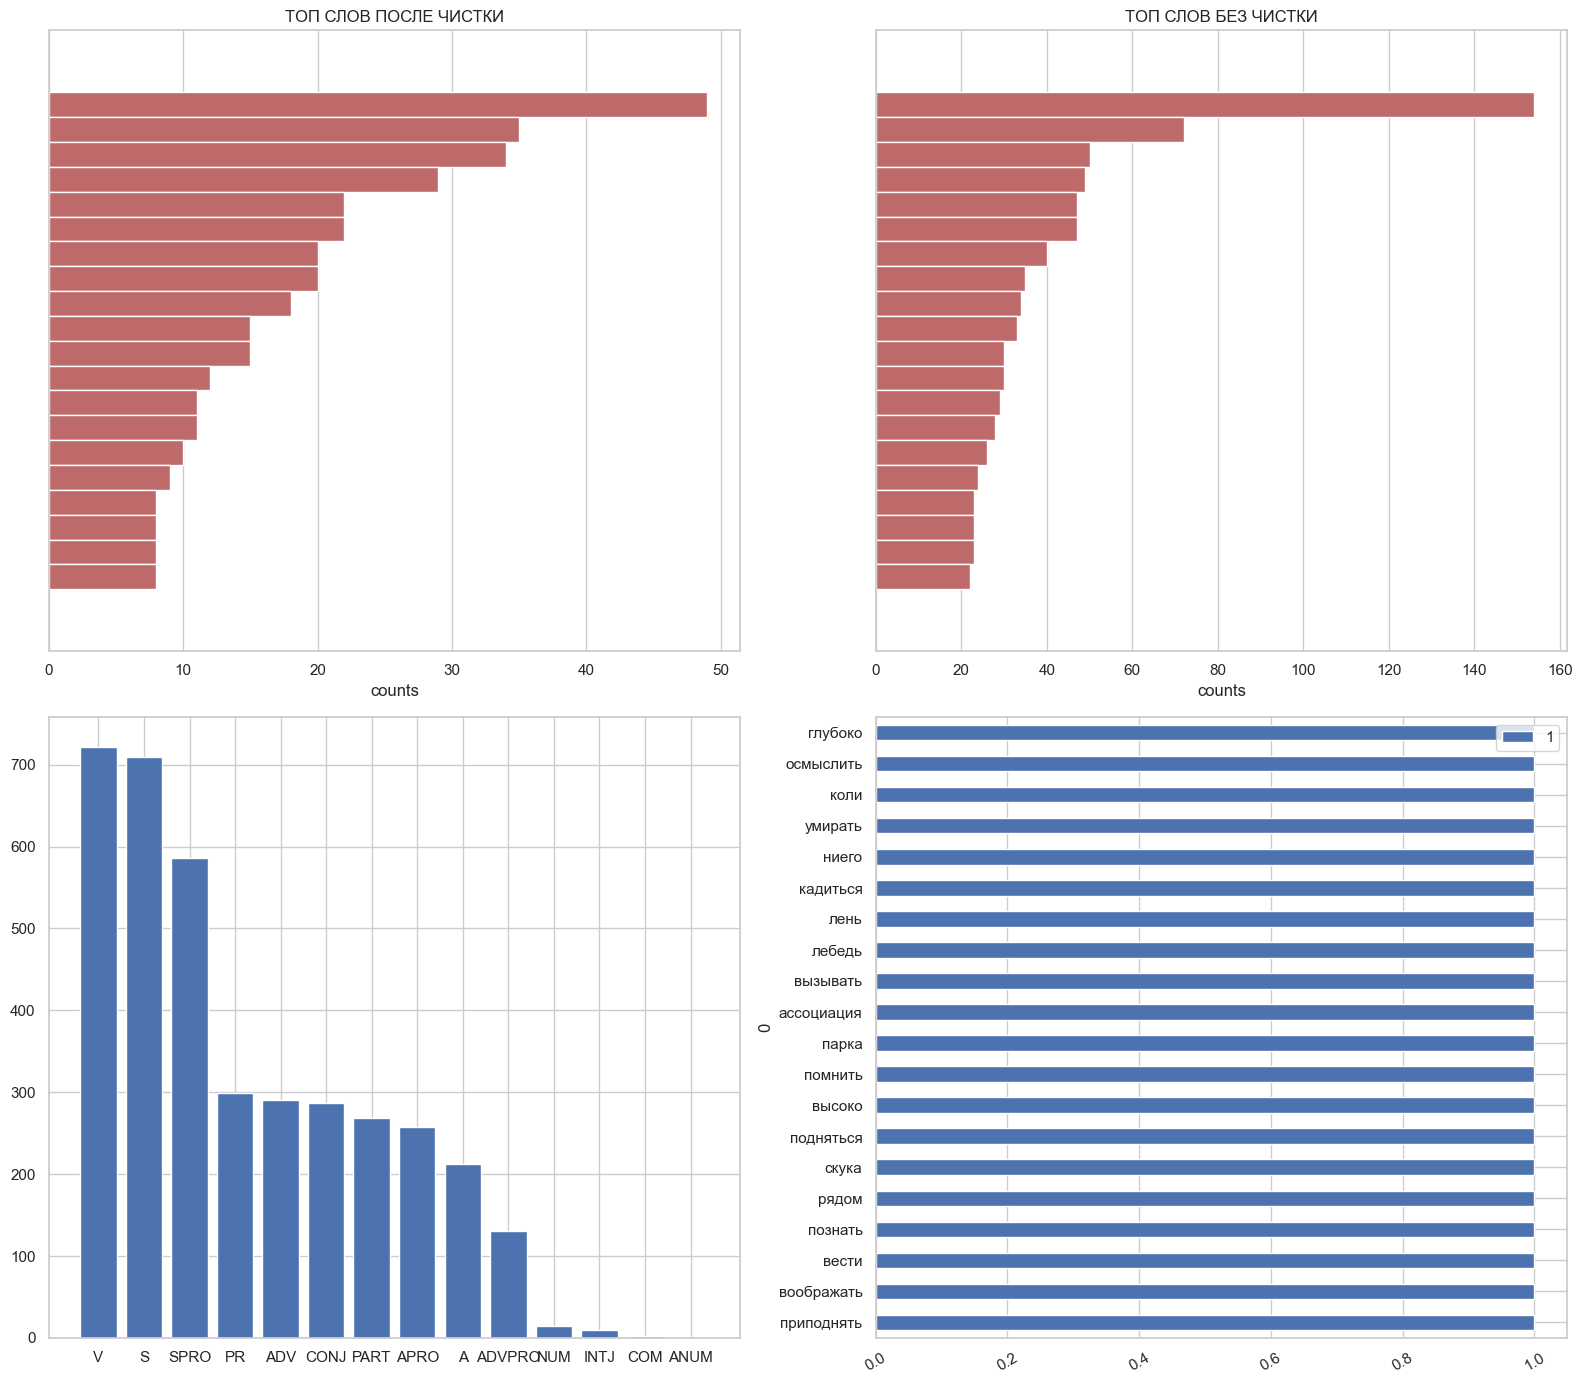

In [29]:
dp=pd.read_csv('persons_daries.csv', sep=',' , low_memory=False)
### тут нужен ввод от пользователя:
id ="7374" #int(input())

### extract all writer's texts by id:
def extract_by_id(id,data):
    if id.isdigit()==False:
        print("айди должен содержать только цифры")
        return [None]
    try:
        extract = data.loc[data['prozhito_id']==int(id)]['text']
        if len(extract)==0:
            print('нет такого айди')
        return pd.DataFrame(extract.apply(lambda x:re.sub(r'<[^>]+>', '', x)))
    except:
        print('ошибка')
        return [None]
    

def len_sent(tdf):
    tdf['sent_count'] = tdf['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
    tdf['word_count'] = tdf['text'].apply(lambda x:len(nltk.word_tokenize(x)))
    tdf['word_per_sent'] = tdf['word_count']/tdf['sent_count']
    word_per_sent = tdf['word_per_sent'].mean()
    return round(word_per_sent) 
# print(f'-------СРЕДНЕЕ КОЛИЧЕСТВО СЛОВ В ПРЕДЛОЖЕНИИ РАВНО ~ {round(word_per_sent)}--------') 

def plot_dirty(tdf, ax):
    count_vect_total = CountVectorizer(ngram_range=(1,1), min_df=5)

    corpus_total = [x for x in tdf['text'].fillna(' ') if len(str(x)) > 0]

    corpus_total_fit = count_vect_total.fit_transform(corpus_total)
    total_counts = pd.DataFrame(corpus_total_fit.toarray(), columns=count_vect_total.get_feature_names_out()).sum()
    ngram_total_df = pd.DataFrame(total_counts, columns=['counts'])

    #sns.set(style="whitegrid")
    ngram_total_df = ngram_total_df.sort_values(by='counts', ascending=False)
    
    plot_dirty = sns.barplot(x="counts",
                             #y=ngram_total_df.head(20).index,
                             ax=ax,
                             data=ngram_total_df.head(20),
                             palette=["indianred"],
                             hue=ngram_total_df.head(20).index,
                             legend=False).set_title('TОП СЛОВ БЕЗ ЧИСТКИ')
    return plot_dirty

def plot_clean(tdf, ax):
    text = str(tdf['text'].values)#.astype('str')
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    count_vect_total = CountVectorizer(ngram_range=(1,2),min_df=5)
    corpus_total = [x for x in filtered_tokens if (str(x) not in stop_words) and (len(x)>3)]


    corpus_total_fit = count_vect_total.fit_transform(corpus_total)#(corpus_total)

    total_counts = pd.DataFrame(corpus_total_fit.toarray(),columns=count_vect_total.get_feature_names_out()).sum()
    ngram_total_df = pd.DataFrame(total_counts,columns=['counts'])

    ngram_total_df = ngram_total_df.sort_values(by=['counts'],ascending=False)
    sns.set_theme(style="whitegrid")
    
    plot_clean = sns.barplot(x="counts",
                            #y=ngram_total_df.head(20).index,
                            data=ngram_total_df.head(20),
                            palette=["indianred"],
                            hue=ngram_total_df.head(20).index,
                            legend=False, ax=ax).set_title('TОП СЛОВ ПОСЛЕ ЧИСТКИ')
                    
    return plot_clean

def lemmatize(wrds, m):
    res = []
    for wrd in wrds:
        p = m.parse(wrd)[0]
        res.append(p.normal_form)
        
    return res

def tokenize(text, stoplst):
    without_stop_words = []
    txxxt = nltk.word_tokenize(text)
    for word in txxxt:
        if len(word) == 1:
            continue
        if word.lower() not in stoplst:
            without_stop_words.append(word)
    return without_stop_words

def process_and_visualize(stop_words, tdf, ax):
    text = str(tdf['text'].values)
    
    def pre_process(text):
        text = re.sub(r"</?.*?>", " <> ", str(text))
        text = re.sub(r"(\\d|\\W)+", "", text)
        text = re.sub(r'[^а-яА-Я\s]+', ' ', text)
        text = text.lower()
        text = re.sub(r"\r\n", " ", text)
        text = re.sub(r"\xa0", " ", text)
        sub_str = 'sfgff'
        text = text[:text.find(sub_str)]
        return text

    morph = pymorphy2.MorphAnalyzer()

    cleaned_text = pre_process(text)
    tokenized_text = tokenize(cleaned_text, stop_words)
    lemmatized_text = lemmatize(tokenized_text, morph)

    Fdist = FreqDist(lemmatized_text)

    #top = Fdist.plot(20, cumulative=False)

    not_most_common = Fdist.most_common()[-21:-1]
    #plt.title("---Топ редких слов:---")
    not_most_common = pd.DataFrame(not_most_common)
    not_most_common.plot(x=0, y=1, ax=ax, rot=0, kind='barh')
    

    return not_most_common


# top pos:
def plot_pos(tdf, ax):
    m = Mystem(disambiguation=False)
    pos_counter_bk = Counter()
    text = str(tdf['text'].values)#text = ' '.join(str(sent) for sent in tdf[0].values)

    for sentence in sent_tokenize(text, language="russian"): 
        print
        doc = m.analyze(sentence)
        for word in doc: 
            if "analysis" not in word or len(word["analysis"]) == 0: 
                continue

            gr = word["analysis"][0]['gr']
            pos = gr.split("=")[0].split(",")[0]
            pos_counter_bk[pos] += 1 
            #if pos == 'V':  # Filter for verbs only
            #    pos_counter_bk[pos] += 1 

    pos_tags = []
    counts = []

    for pos, count in pos_counter_bk.most_common():
        pos_tags.append(pos)
        counts.append(count)

    bk_plt = ax.bar(pos_tags, counts)
    plt.xticks(rotation=30)
    
    return bk_plt
  
def plot_top_names(ax):
    def names_extr(wrds):
        morph = pymorphy2.MorphAnalyzer()
        res = []
        for wrd in wrds:
            p = morph.parse(wrd)[0]
            if 'Name' in p.tag:
                res.append(wrd)
        return res

    is_name = names_extr(m.lemmatize(tokenize(text,stop_words)))
    Fdist = FreqDist(is_name)
    plt.title("Топ имен на линейном графике:")
    plot_top_names=Fdist.plot(20, cumulative = False, ax=ax)
    return plot_top_names

### apply:
tdf = extract_by_id(id,dp)
text = str(tdf['text'].values)

print('Обработано записей: ', len(tdf))
print(f"СРЕДНЕЕ КОЛИЧЕСТВО СЛОВ В ПРЕДЛОЖЕНИИ РАВНО ~ {len_sent(tdf)}")

def plot_all_graphs(tdf):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 14))

    plot_clean(tdf, axs[0, 0])
    # Вызовите остальные функции и передайте им соответствующий объект ax
    plot_dirty(tdf, axs[0, 1])
    plot_pos(tdf, axs[1, 0])
    process_and_visualize(stop_words, tdf, axs[1, 1])
    #plot_top_names(axs[2, 0])
    fig.tight_layout()
    
    return fig


plot_all_graphs(tdf)

In [30]:
import telebot

TOKEN='6742100930:AAFWmK2R_8StqyA3QmHZpsQFwG4kwbwDam8'
bot = telebot.TeleBot(TOKEN)
bot.delete_webhook()

True

In [32]:
print(type(dp))

<class 'pandas.core.frame.DataFrame'>
